In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn import metrics
from sklearn.pipeline import Pipeline
from scipy import stats
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, mean_squared_error, r2_score
from nltk.corpus import stopwords

source_folder = '../data/twitter_data/'

In [2]:
def clean_data(DataFrame):
    stop_words = stopwords.words('english')
    stop_words.remove('not')
    stop_words.remove('no') 
    # remove stop words
    DataFrame['tweet_text'] = DataFrame['tweet_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
    # remove punctuation
    DataFrame['tweet_text'] = DataFrame['tweet_text'].str.replace('[^\w\s]','')
    # remove numbers
    DataFrame['tweet_text'] = DataFrame['tweet_text'].str.replace('\d+', '')
    # remove http links
    DataFrame['tweet_text'] = DataFrame['tweet_text'].str.replace('http\S+|www.\S+', '', case=False)
    
    return DataFrame

In [3]:
train = pd.read_csv(source_folder+'/tweet_train.csv', sep=',')
test = pd.read_csv(source_folder+'/new_tweet_data_clean.csv', sep=',')
test = clean_data(test)
# remove id column
test = test.drop(['id'], axis=1)
# rename columns
test = test.rename(columns={'tweet_text': 'Tweet', 'label': 'label'})
new_tweet_data_clean = test.to_csv(source_folder+'/new_tweet_data_clean.csv', index=False)

KeyError: 'tweet_text'

In [ ]:
train['Tweet'] = train['Tweet'].str.lower()
test['Tweet'] = test['Tweet'].str.lower()

In [7]:
X_train = train['Tweet'].fillna(' ')
y_train = train['label'].fillna(' ')
X_test = test['Tweet'].fillna(' ')
y_test = test['label'].fillna(' ')

In [8]:
pipeline = Pipeline([
    ('vect', CountVectorizer(binary=True, analyzer='char', ngram_range=(1,5), min_df = 10, max_df = 0.95)),
    ('tfidf', TfidfTransformer(sublinear_tf=True)),
    ('clf', LogisticRegression(C=10, max_iter=1000))
])

In [9]:
# train the model
pipeline.fit(X_train, y_train)

# predict the test set
y_pred = pipeline.predict(X_test)

In [10]:
print("AUC score: ", roc_auc_score(y_test, y_pred))
print("Accuracy : ", metrics.accuracy_score(y_test, y_pred))

AUC score:  0.7694557080474111
Accuracy :  0.8580775037745345


In [11]:
print('Mean Squared Error: ', mean_squared_error(y_test, y_pred))
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

Mean Squared Error:  0.14192249622546552
Coefficient of determination: 0.09


In [12]:
feature_importance = pipeline['clf'].coef_[0][:10]
for i,v in enumerate(feature_importance):
    print('Feature: ', list(pipeline['vect'].vocabulary_.keys())[list(pipeline['vect'].vocabulary_.values()).index(i)], 'Score: ', v)

Feature:  
 Score:  1.6156513332312483
Feature:  
# Score:  -0.35800857065284025
Feature:  
#a Score:  0.07856877795254533
Feature:  
#b Score:  0.10305695162395977
Feature:  
#h Score:  -0.5020825910255783
Feature:  
#ho Score:  -0.10763976214670289
Feature:  
#s Score:  0.03297611762009541
Feature:  
- Score:  -0.5703803666486397
Feature:  
2 Score:  -0.14080692739787892
Feature:  
@ Score:  1.0915343253561243


In [13]:
feature_importance = pipeline['clf'].coef_[0]
sorted_idx = np.argsort(feature_importance)

In [14]:
top_10 = [list(pipeline['vect'].vocabulary_.keys())[list(pipeline['vect'].vocabulary_.values()).index(w)] for w in sorted_idx[range(-1,-11, -1)]]
print(top_10)

['ass', 'ss', ' ass', 'ass ', ' as', 'lut', ' ass ', 'slut', 'slu', 'ss ']


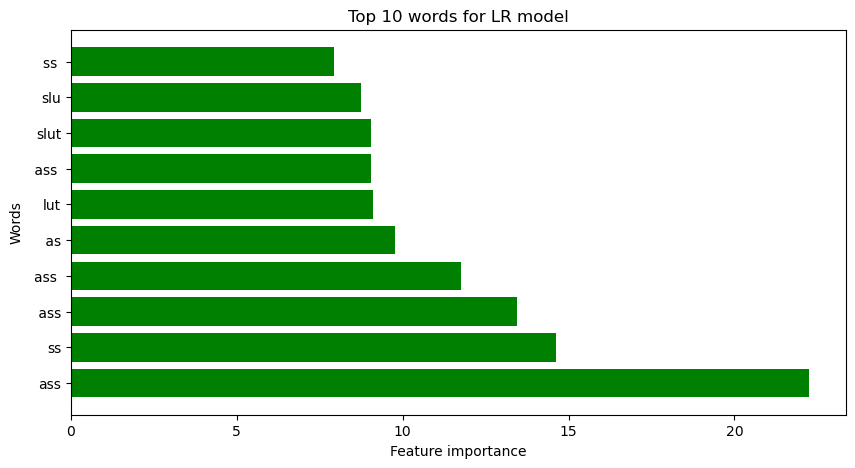

In [15]:
# word vector plot for top 10 words
plt.figure(figsize=(10,5))
plt.barh(top_10, feature_importance[sorted_idx[range(-1,-11, -1)]], color='g', align='center')
plt.title('Top 10 words for LR model')
plt.xlabel('Feature importance')
plt.ylabel('Words')
# save
plt.savefig('../figures/LR_top10_words.png')
plt.show()

In [16]:
sub_f = train.loc[train.Tweet.str.contains('ass')]
round(sub_f.label.mean(),3)

0.857

In [17]:
top_10_non = [list(pipeline['vect'].vocabulary_.keys())[list(pipeline['vect'].vocabulary_.values()).index(w)] for w in sorted_idx[:10]]
print(top_10_non)

['os', 'as ', 'iss', 'rey', 'ay', 'r c', ' as ', 'in a', 'lar', 't on']


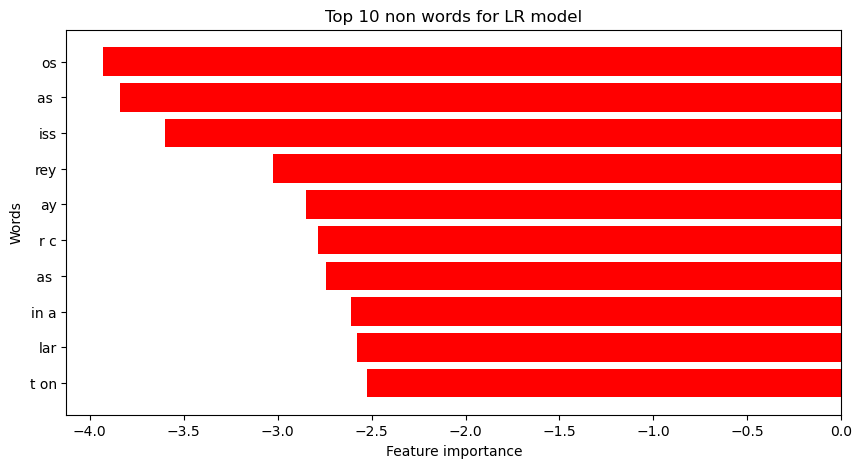

In [19]:
# word vector plot for top 10 non words
plt.figure(figsize=(10,5))
plt.barh(top_10_non, feature_importance[sorted_idx[range(10)]], color='r')
# get y-axis labels
plt.title('Top 10 non words for LR model')
plt.xlabel('Feature importance')
plt.ylabel('Words')
# save
plt.savefig('../figures/LR_top10_non_words.png')
plt.show()